In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tabular_simple import TabularSimple, TabularNormal
from generator import Generator
from discriminator import Discriminator
from rollout_max_ent import ROLLOUT
import tensorflow as tf
from gan_trainer import GanTrainer
from dataloader import Gen_Data_loader, Dis_dataloader

/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/zhome/30/0/70339/.local/lib/python3.6/site-packages/tensorflow/python/frame

In [3]:
n_modes = 2
vocab_size = 30
vocab = range(vocab_size)
SEQ_LENGTH = 4
#tabular_model = TabularSimple(SEQ_LENGTH,n_vocabulary,n_modes)
tabular_model = TabularNormal(SEQ_LENGTH,vocab_size,n_modes)

<BarContainer object of 30 artists>

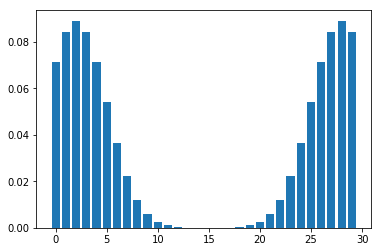

In [4]:
dist = tabular_model.table[""]
plt.bar(vocab, dist)

In [5]:
size = 10000
samples = tabular_model.sample(size)

In [6]:
positive_file = 'save/real_data_tab_simple.txt'

In [7]:
np.savetxt(positive_file,samples,fmt='%d',delimiter=' ')

In [8]:
len(list(tabular_model.table.keys()))

27931

In [9]:
tabular_model.ll(samples)

-2.7922480562402905

In [10]:
g1 = tf.Graph()
g2 = tf.Graph()

In [11]:
#########################################################################################
#  Generator  Hyper-parameters
######################################################################################
EMB_DIM = 4 # embedding dimension
HIDDEN_DIM = 4 # hidden state dimension of lstm cell
#SEQ_LENGTH = 4 # sequence length
START_TOKEN = -1
PRE_EPOCH_NUM = 120 # supervise (maximum likelihood estimation) epochs
SEED = 88
BATCH_SIZE = 256

#########################################################################################
#  Discriminator  Hyper-parameters
#########################################################################################
dis_embedding_dim = 4
dis_filter_sizes = [1, 2, 3, 4]
dis_num_filters = [200, 200, 200, 200]
#dis_num_filters = [10, 10, 10, 10]
dis_dropout_keep_prob = 1.0
dis_l2_reg_lambda = 0.2
dis_batch_size = 32

#########################################################################################
#  Basic Training Parameters
#########################################################################################
TOTAL_BATCH = 200
#positive_file = 'save/real_data_tab.txt'
negative_file = 'save/generator_sample_tab.txt'
negative_file_ent = 'save/generator_sample_tab_ent.txt'
#eval_file = 'save/eval_file_tab.txt'
generated_num = 10000
sequence_length = 6
g_lr = 0.01
with g1.as_default():
    generator = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN,learning_rate=g_lr)
    discriminator = Discriminator(sequence_length=SEQ_LENGTH, num_classes=2, vocab_size=vocab_size, embedding_size=dis_embedding_dim, 
                            filter_sizes=dis_filter_sizes, num_filters=dis_num_filters, l2_reg_lambda=dis_l2_reg_lambda)
    rollout = ROLLOUT(generator, 0.8)
    gen_data_loader = Gen_Data_loader(BATCH_SIZE,SEQ_LENGTH)
    dis_data_loader = Dis_dataloader(BATCH_SIZE,SEQ_LENGTH)
    gan_trainer = GanTrainer(generator,discriminator,rollout,gen_data_loader,dis_data_loader,
           tabular_model,'pretrain_notebook','advtrain_notebook',positive_file,negative_file,BATCH_SIZE)
    graph1_init_op = tf.global_variables_initializer()
    saver1 = tf.train.Saver()
with g2.as_default():
    generator_ent = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN,learning_rate=g_lr)
    discriminator_ent = Discriminator(sequence_length=SEQ_LENGTH, num_classes=2, vocab_size=vocab_size, embedding_size=dis_embedding_dim, 
                            filter_sizes=dis_filter_sizes, num_filters=dis_num_filters, l2_reg_lambda=dis_l2_reg_lambda)
    rollout_ent = ROLLOUT(generator_ent, 0.8)
    gen_data_loader_ent = Gen_Data_loader(BATCH_SIZE,SEQ_LENGTH)
    dis_data_loader_ent = Dis_dataloader(BATCH_SIZE,SEQ_LENGTH)
    gan_trainer_ent = GanTrainer(generator_ent,discriminator_ent,rollout_ent,gen_data_loader_ent,dis_data_loader_ent,
           tabular_model,'pretrain_notebook','advtrain_notebook',positive_file,negative_file_ent,BATCH_SIZE)
    graph2_init_op = tf.global_variables_initializer()
    saver2 = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess1 = tf.Session(config=config,graph=g1)
sess2 = tf.Session(config=config,graph=g2)

In [13]:
# run from saved checkpoint 
#saver = tf.train.Saver()
#tf.reset_default_graph()
#saver.restore(sess, 'model/pretrain_max_ent_tab.ckpt')
#saver.restore(sess, 'model/advtrain.ckpt')

In [14]:
sess1.run(graph1_init_op)
sess2.run(graph2_init_op)

In [15]:
gan_trainer.pretrain(sess1, 60, 20,3,
    saver1,dis_dropout_keep_prob,generated_num)
gan_trainer_ent.pretrain(sess2, 60, 20,3,
    saver2,dis_dropout_keep_prob,generated_num)

Start pre-training...
pre-train epoch  0 test_loss  5.929840646741397
pre-train epoch  5 test_loss  4.450525154048021
pre-train epoch  10 test_loss  4.527355891289067
pre-train epoch  15 test_loss  4.470251583786372
pre-train epoch  20 test_loss  4.638762656888222
pre-train epoch  25 test_loss  4.258336541634362
pre-train epoch  30 test_loss  4.3718469664525195
pre-train epoch  35 test_loss  4.366219908730117
pre-train epoch  40 test_loss  4.4203765926253125
pre-train epoch  45 test_loss  4.343329580541223
pre-train epoch  50 test_loss  4.2369345537615715
pre-train epoch  55 test_loss  4.404506965635685
Start pre-training discriminator...
pre-train entropy:  3.0860715
Start pre-training...
pre-train epoch  0 test_loss  6.010373646447311
pre-train epoch  5 test_loss  4.824583330648426
pre-train epoch  10 test_loss  4.388737074419119
pre-train epoch  15 test_loss  4.228520178546573
pre-train epoch  20 test_loss  4.331465741301237
pre-train epoch  25 test_loss  4.330733914074049
pre-train

In [182]:
#EVEN WITH A VERY HIGH ENTROPY CONSTANT WE DON't see any major difference

In [183]:
for it in range(50):
    for temp, gen, disc, gan, saver, sess in zip([9999,.5],[generator,generator_ent],
            [discriminator,discriminator_ent],[gan_trainer, gan_trainer_ent],[saver1,saver2],[sess1,sess2]):
        _, g_loss = gan.advtrain_gen(sess,1,64,temp)
        if it % 10 == 0:
            class_ = 1
            test_loss = - tabular_model.ll(np.concatenate([gen.generate(sess) for _ in range(100)]))
            policy_ent = np.mean([sess.run(gen.pretrain_loss,
                {gen.x: gen.generate(sess) }) for _ in range(10)])
        
            disc_loss = np.mean(np.concatenate([sess.run(disc.ypred_for_auc, 
                {disc.input_x: gen.generate(sess), disc.dropout_keep_prob: 
                 dis_dropout_keep_prob})[:,class_] for _ in range(10)]))
            print("GenT: {:.4f} -  test_loss: {:.4f}, g_loss: {:.4f}, pol_ent: {:.4f}, ll_disc: {:.4f}"
                .format(temp, test_loss, g_loss,policy_ent,disc_loss))

GenT: 9999.0000 -  test_loss: 4.3320, g_loss: 113.3325, pol_ent: 2.9946, ll_disc: 0.3088
GenT: 0.5000 -  test_loss: 4.2894, g_loss: 147.5757, pol_ent: 2.9758, ll_disc: 0.3156
GenT: 9999.0000 -  test_loss: 4.3022, g_loss: 60.8039, pol_ent: 2.9886, ll_disc: 0.3298
GenT: 0.5000 -  test_loss: 4.2663, g_loss: 64.7220, pol_ent: 2.9947, ll_disc: 0.3266
GenT: 9999.0000 -  test_loss: 4.2959, g_loss: 14.5526, pol_ent: 3.0021, ll_disc: 0.3649
GenT: 0.5000 -  test_loss: 4.2686, g_loss: 102.1926, pol_ent: 3.0043, ll_disc: 0.3612
GenT: 9999.0000 -  test_loss: 4.2908, g_loss: -62.0156, pol_ent: 2.9891, ll_disc: 0.4099
GenT: 0.5000 -  test_loss: 4.3119, g_loss: 70.0566, pol_ent: 3.0122, ll_disc: 0.3791
GenT: 9999.0000 -  test_loss: 4.4271, g_loss: -73.0692, pol_ent: 2.9720, ll_disc: 0.4480
GenT: 0.5000 -  test_loss: 4.3315, g_loss: 30.1151, pol_ent: 3.0110, ll_disc: 0.4393


In [184]:
np.mean([sess1.run(generator.pretrain_loss,
                {generator.x: generator.generate(sess1) }) for _ in range(10)])

2.920297

In [185]:
np.mean([sess2.run(generator_ent.pretrain_loss,
                {generator_ent.x: generator_ent.generate(sess2) }) for _ in range(10)])

2.9569912

In [186]:
np.mean(np.concatenate([sess1.run(discriminator.ypred_for_auc, {discriminator.input_x: generator.generate(sess1), discriminator.dropout_keep_prob: dis_dropout_keep_prob})[:,class_] for _ in range(10)]))

0.46981817

In [187]:
np.mean(np.concatenate([sess2.run(discriminator_ent.ypred_for_auc, {discriminator_ent.input_x: generator_ent.generate(sess2), discriminator_ent.dropout_keep_prob: dis_dropout_keep_prob})[:,class_] for _ in range(10)]))

0.4746616

In [188]:
#testloss is not stable

In [189]:
- tabular_model.ll(np.concatenate([generator_ent.generate(sess2) for _ in range(100)]))

4.355631225065371

In [190]:
- tabular_model.ll(np.concatenate([generator.generate(sess1) for _ in range(100)]))

4.4249025282761325

In [191]:
# We see that improving the ll_disc dosn̈́'t mean that the test_loss falls.
# Also It's not super evident that the entropy is not reaaaly different
# For the entropy version with 0.25 we see that ll_disc is not going so much up while training the discrim

In [192]:
for it in range(20):
    for temp, gen, disc, neg_file, gan, saver, sess in zip([9999,.5],[generator,generator_ent],
            [discriminator,discriminator_ent],[negative_file,negative_file_ent],[gan_trainer, gan_trainer_ent],[saver1,saver2],[sess1,sess2]):
        gan.advtrain_disc(sess,saver,1,3,
                BATCH_SIZE, generated_num, positive_file, neg_file, dis_dropout_keep_prob)
        class_ = 1
        predictions = np.array([])
        for i in range(10):
            predictions = np.concatenate((predictions,sess.run(disc.ypred_for_auc, {disc.input_x: gen.generate(sess), disc.dropout_keep_prob: dis_dropout_keep_prob})[:,class_]))
        if it % 2 == 0:
            print("DISC: GenT: {:.4f} - ll_disc: {:.4f}"
                .format(temp, np.mean(np.log(predictions))))


DISC: GenT: 9999.0000 - ll_disc: -1.6216
DISC: GenT: 0.5000 - ll_disc: -1.2777
DISC: GenT: 9999.0000 - ll_disc: -1.4060
DISC: GenT: 0.5000 - ll_disc: -1.6455
DISC: GenT: 9999.0000 - ll_disc: -1.3690
DISC: GenT: 0.5000 - ll_disc: -1.6386
DISC: GenT: 9999.0000 - ll_disc: -1.8370
DISC: GenT: 0.5000 - ll_disc: -1.6328
DISC: GenT: 9999.0000 - ll_disc: -1.8682
DISC: GenT: 0.5000 - ll_disc: -1.7158
DISC: GenT: 9999.0000 - ll_disc: -1.8046
DISC: GenT: 0.5000 - ll_disc: -1.6828
DISC: GenT: 9999.0000 - ll_disc: -1.4033
DISC: GenT: 0.5000 - ll_disc: -2.0194
DISC: GenT: 9999.0000 - ll_disc: -1.5856
DISC: GenT: 0.5000 - ll_disc: -1.8652
DISC: GenT: 9999.0000 - ll_disc: -1.4964
DISC: GenT: 0.5000 - ll_disc: -1.8715
DISC: GenT: 9999.0000 - ll_disc: -1.6938
DISC: GenT: 0.5000 - ll_disc: -1.6086


In [193]:
#ll is not affected too much by training

In [194]:
seq = [START_TOKEN]

<BarContainer object of 30 artists>

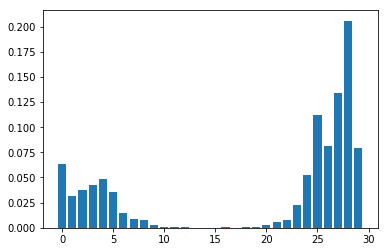

In [195]:
h_t = generator.h0
for token in seq:
    x_t = tf.nn.embedding_lookup(generator.g_embeddings, [token]*BATCH_SIZE)
    h_t = generator.g_recurrent_unit(x_t, h_t)  # hidden_memory_tuple
    o_t = generator.g_output_unit(h_t)  # batch x vocab , logits not prob
#log_prob = tf.log(tf.nn.softmax(o_t))
dist0 = sess1.run(tf.nn.softmax(o_t))[0,:]
plt.bar(vocab, dist0)
#sess1.run(h_t)

<BarContainer object of 30 artists>

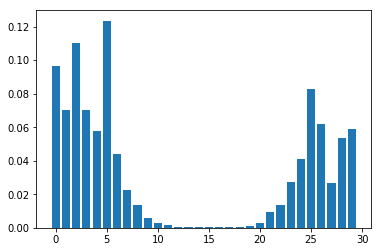

In [196]:
h_t = generator_ent.h0
for token in seq:
    x_t = tf.nn.embedding_lookup(generator_ent.g_embeddings, [token]*BATCH_SIZE)
    h_t = generator_ent.g_recurrent_unit(x_t, h_t)  # hidden_memory_tuple
    o_t = generator_ent.g_output_unit(h_t)  # batch x vocab , logits not prob
#log_prob = tf.log(tf.nn.softmax(o_t))
dist0_ent = sess2.run(tf.nn.softmax(o_t))[0,:]
plt.bar(vocab, dist0_ent)
#sess1.run(h_t)

<BarContainer object of 30 artists>

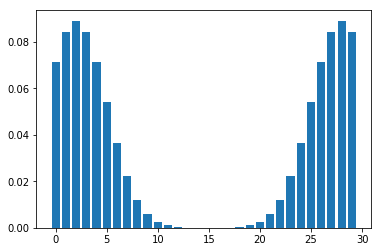

In [197]:
plt.bar(vocab,tabular_model.table[""])